In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import integrate
from scipy import stats
import time

Below, we define distance metrics used within our KNN Classifier model. Euclidean distance corresponds to the $L_2$ norm, and Manhattan distance to the $L_1$ norm. Other norms were not considered within the scope of this report.

In [2]:
''' This function calculates the Euclidean distance between two vectors. '''
def Euclidean(vector1, vector2):
    return np.sqrt(np.abs(vector1**2 - vector2**2).sum())

''' This function calculates the Manhattan distance between two vectors. '''
def Manhattan(vector1, vector2):
    return np.abs(vector1 - vector2).sum()

Next, we define several measures of performance for our KNN Classifier model. Accuracy is merely a measurement of correctness, while the confusion matrix allows us to computer things like precision, recall, and F1 score. Finally, we have ROC and AUC functions, which take as input the TPR and FPR of multiple runs and plot the precision and recall. The precision-recall curve does the same, for a vector of precisions, recalls, and thresholds.

In [3]:
''' This function calculates the Accuracy between a vector of expected values
and a vector of predicted values. '''
def Accuracy(expected, predicted):
    correct = np.where(expected.values == predicted.values, 1, 0).sum()
    accuracy = correct/expected.size
    gen_error = 1 - accuracy
    return accuracy, gen_error

''' ConfusionMatrix generates a confusion matrix, taking in a vector of
predicted results, actual results, and the result being predicted, p. '''
def ConfusionMatrix(expected, predicted, p=1):
    # Convert dataframe to numpy arrays.
    expected = expected.values
    predicted = predicted.values
    # TP occurs when our prediction aligns with actual data, and prediction is p.
    TP = np.where(((predicted == expected) & (p == predicted)), 1, 0).sum()
    # FP occurs when our prediction is incorrect, but prediction is still p.
    FP = np.where(((predicted != expected) & (p == predicted)), 1, 0).sum()
    # TN occurs when our prediction is correct and is not p.
    TN = np.where(((predicted == expected) & (p != predicted)), 1, 0).sum()
    # FN occurs when our prediction is incorrect, and we predict not p.
    FN = np.where(((predicted != expected) & (p != predicted)), 1, 0).sum()
    # Put values into a matrix, return confusion matrix.
    confusion_matrix = np.array([[TP, FP],
                                 [FN, TN]])
    return confusion_matrix

''' This function uses the confusion matrix to get the precision, given a vector
of expected values and a vector of predicted ones. See ConfusionMatrix for 
optional arguments (notably p, if expected is something other than 1.'''
def Precision(expected, predicted, **kwargs):
    cm = ConfusionMatrix(expected, predicted, kwargs.pop('p', 1))
    return cm[0][0]/(cm[0][0] + cm[0][1])

''' This function uses the confusion matrix to get the recall, given a vector
of expected values and a vector of predicted ones. See ConfusionMatrix for 
optional arguments (notably p, if expected is something other than 1.'''
def Recall(expected, predicted, **kwargs):
    cm = ConfusionMatrix(expected, predicted, kwargs.pop('p', 1))
    return cm[0][0]/(cm[0][0] + cm[1][0])

''' This function uses the confusion matrix to get the F1 Score, given a vector
of expected values and a vector of predicted ones. See ConfusionMatrix for 
optional arguments (notably p, if expected is something other than 1.'''
def F1_Score(expected, predicted, **kwargs):
    cm = ConfusionMatrix(expected, predicted, kwargs.pop('p', 1)) 
    return cm[0][0]/(cm[0][0] + (cm[1][0] + cm[0][1])/2)

''' The ROC function should take a vector of TPR and FPR values for various
thresholds of acceptance, and plots them against each other in an ROC curve. '''
def ROC(TPR, FPR):
    plt.axis([0, 1, 0, 1])
    plt.title('ROC')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    return plt.plot(FPR, TPR)

''' This function calculates the area under the ROC curve, given a vector of
TPR and FPR values that define the ROC curve. '''
def AUC(TPR, FPR):
    auc = integrate.trapz(TPR, FPR)
    return auc

def PrecisionRecallCurve(precision, recall, threshold):
    fig, ax = plt.subplots()
    ax.set_xlabel('Threshold')
    ax.plot(thresholds, precision, label='precision')
    ax.plot(thresholds, recall, label='recall')
    ax.legend(loc='upper right')

Now we write a function to partition training and testing data in a specified proportion.

In [4]:
''' Partition splits data into train and test. It takes three arguments:
    the feature matrix, the target vector, and the partition size t.
    t should be between 0 and 1, and is the percentage of test data. '''
def partition(feature_matrix, target_vector, t):
    # Generate a random range of values between 0 and 1.
    rng = np.random.random(target_vector.size)
    # If the number generated above is > t, put in training, else put in test.
    rng_over_t = np.where(rng > t, True, False)
    # Apply mask to features.
    train_features = feature_matrix[rng_over_t]
    test_features = feature_matrix[~rng_over_t]
    # Apply mask to target.
    train_target = target_vector[rng_over_t]
    test_target = target_vector[~rng_over_t]
    return train_features, test_features, train_target, test_target

We define the KNN Classifier model below. It fits onto data and employs a brute-force prediction algorithm to classify new sets of points according to the distance between their features and points within the fitted data.

In [5]:
''' The KNN_Classifier class defines our K-Nearest-Neighbor implemenation with
the brute-force algorithm. '''
class KNN_Classifier:
    def __init__(self):
        pass
    
    ''' The fit function 'feeds' our KNN algorithm initially with features X
    and a target vector Y. We can also specify k with n_neighbors, the type
    of weighting (default: uniform, or distance), threshold for acceptance 
    by default 0.5, and metric for determining distance, by default Euclidean.'''
    def fit(self, X, Y, n_neighbors, weights='uniform', **kwargs):
        self.X = X
        self.Y = Y
        self.n_neighbors = n_neighbors
        if weights=='distance':
            self.weights = 'distance'
        else:
            self.weights = 'uniform'
        self.threshold = kwargs.pop('threshold', 0.5)
        self.metric = kwargs.pop('metric', Euclidean)
        
    ''' The predict function takes as input a set of features, X, and makes
    classification predictions from those features based on fit defined above. '''
    def predict(self, X):
        self.predictions = np.array([])
        if self.weights == 'uniform':
            # Iterate through every point of testing data.
            for sample_row in X.values:
                dist = np.array([])
                # Compare distance of testing points to fitted points.
                for known_row in self.X.values:
                    dist = np.append(dist, self.metric(sample_row, known_row))
                # Get closest n_neighbors to each sample, using argsort()
                indices = dist.argsort()[:self.n_neighbors]
                # self.Y.values[indices] returns 0's or 1's corresponding to the selected distances above.
                # Taking their mean is a poll of the nearest points. Check this poll exceeds the threshold.
                if self.Y.values[indices].mean() >= self.threshold:
                    self.predictions = np.append(self.predictions, 1)
                else:
                    self.predictions = np.append(self.predictions, 0)

        elif self.weights == 'distance':
            # Iterate through every point of testing data.
            for sample_row in X.values:
                dist = np.array([])
                # Compare distance of testing points to fitted points.
                for known_row in self.X.values:
                    dist = np.append(dist, self.metric(sample_row, known_row))
                # Get closest n_neighbors to each sample.
                indices = dist.argsort()[:self.n_neighbors]
                # self.Y.values[indices] returns 0's or 1's corresponding to the selected distances above.
                # Weight these by the inverse distance, i.e., divide by the corresponding distances.
                # Taking their mean is a poll of the nearest points. Check this poll exceeds the threshold.
                if (self.Y.values[indices] / dist[indices]).mean() >= self.threshold:
                    self.predictions = np.append(self.predictions, 1)
                else:
                    self.predictions = np.append(self.predictions, 0)
        # Convert NumPy array of predictions back into dataframe, for consistency.
        self.predictions = pd.Series(self.predictions)

We write an sFold function below, which breaks up training data into a specified number of partitions, then predicts the values of each partition based on data fitted from all other partitions.

In [6]:
''' sFold takes as input the number of folds, the training features and target,
the model class, and an error function. It divides the training features/target
randomly into 'folds' partitions, then isolates partitions one-by-one and makes
predictions of them from the other partitions. It outputs expected and predicted
values, as well as the average error across all partition runs, in a dictionary.'''                    
def sFold(folds, data, labels, model, error_function, **model_args):
    print(type(data), type(labels))
    # Check for kwargs which must be inputted manually into KNN_Classifier.
    n_neighbors = model_args.pop('n_neighbors', 5)
    weights = model_args.pop('weights', 'uniform')
    ''' This is a helper function which splits data into 'folds' parts, and
    then puts each of these parts into a dictionary, labeled by their number
    and with values which are tuples of partitioned (data, labels).'''
    def s_partition(folds, data, labels):
        parts = {}
        rng = np.random.randint(0, folds, size=labels.size)
        for s in range(folds):
            parts[s] = (data.loc[rng == s], labels.loc[rng == s])
        return parts
    
    # Split data.
    parts = s_partition(folds, data, labels)

    # Initialize output dictionary.
    output = {'expected': pd.DataFrame(), 'predicted': pd.DataFrame(), 'average error': np.nan}
    # Run through each partition, isolating them one-by-one.
    for iso in parts:
        # Need to copy dict to drop the isolated part.
        without_iso = parts.copy()
        without_iso.pop(iso)
        # Need to accumulate all the data for non-isolated parts.
        data_wo_iso = pd.DataFrame()
        labels_wo_iso = pd.DataFrame()
        for part in without_iso:
            data_wo_iso = pd.concat((data_wo_iso, without_iso[part][0]), axis=0)
            labels_wo_iso = pd.concat((labels_wo_iso, without_iso[part][1]), axis=0)
        knn = KNN_Classifier()
        # Make our knn model, fit it to the accumulated, non-isolated parts.
        knn.fit(X=data_wo_iso, Y=labels_wo_iso, n_neighbors=n_neighbors, weights=weights, **model_args)
        # Prediction of current partition. Actual target is parts[iso][1].
        knn.predict(parts[iso][0])
        predicted = knn.predictions
        expected = parts[iso][1]
        # Calculate the error for this run.
        # Store everything in the output dict. Label dict by isolated part.
        output['expected'] = pd.concat((output['expected'], expected), axis=0)
        output['predicted'] = pd.concat((output['predicted'], predicted), axis=0)
    # Get error across all partition predictions.
    output['average error'] = error_function(output['expected'], output['predicted'])
    return output

Now we can import our data and do some testing on our KNN algorithm.

In [7]:
# Read in csv file.
df = pd.read_csv('winequality-white.csv', sep=';')
# Assign good or bad.
df['quality'] = np.where(df['quality'] > 5, 1, 0)
# Get statistical data.
basic_stats = df.describe()
# Shuffle dataset rows.
df = df.sample(frac=1)

But first, some analysis! We need to see if there are any correlated features, and drop them to avoid redundancy.

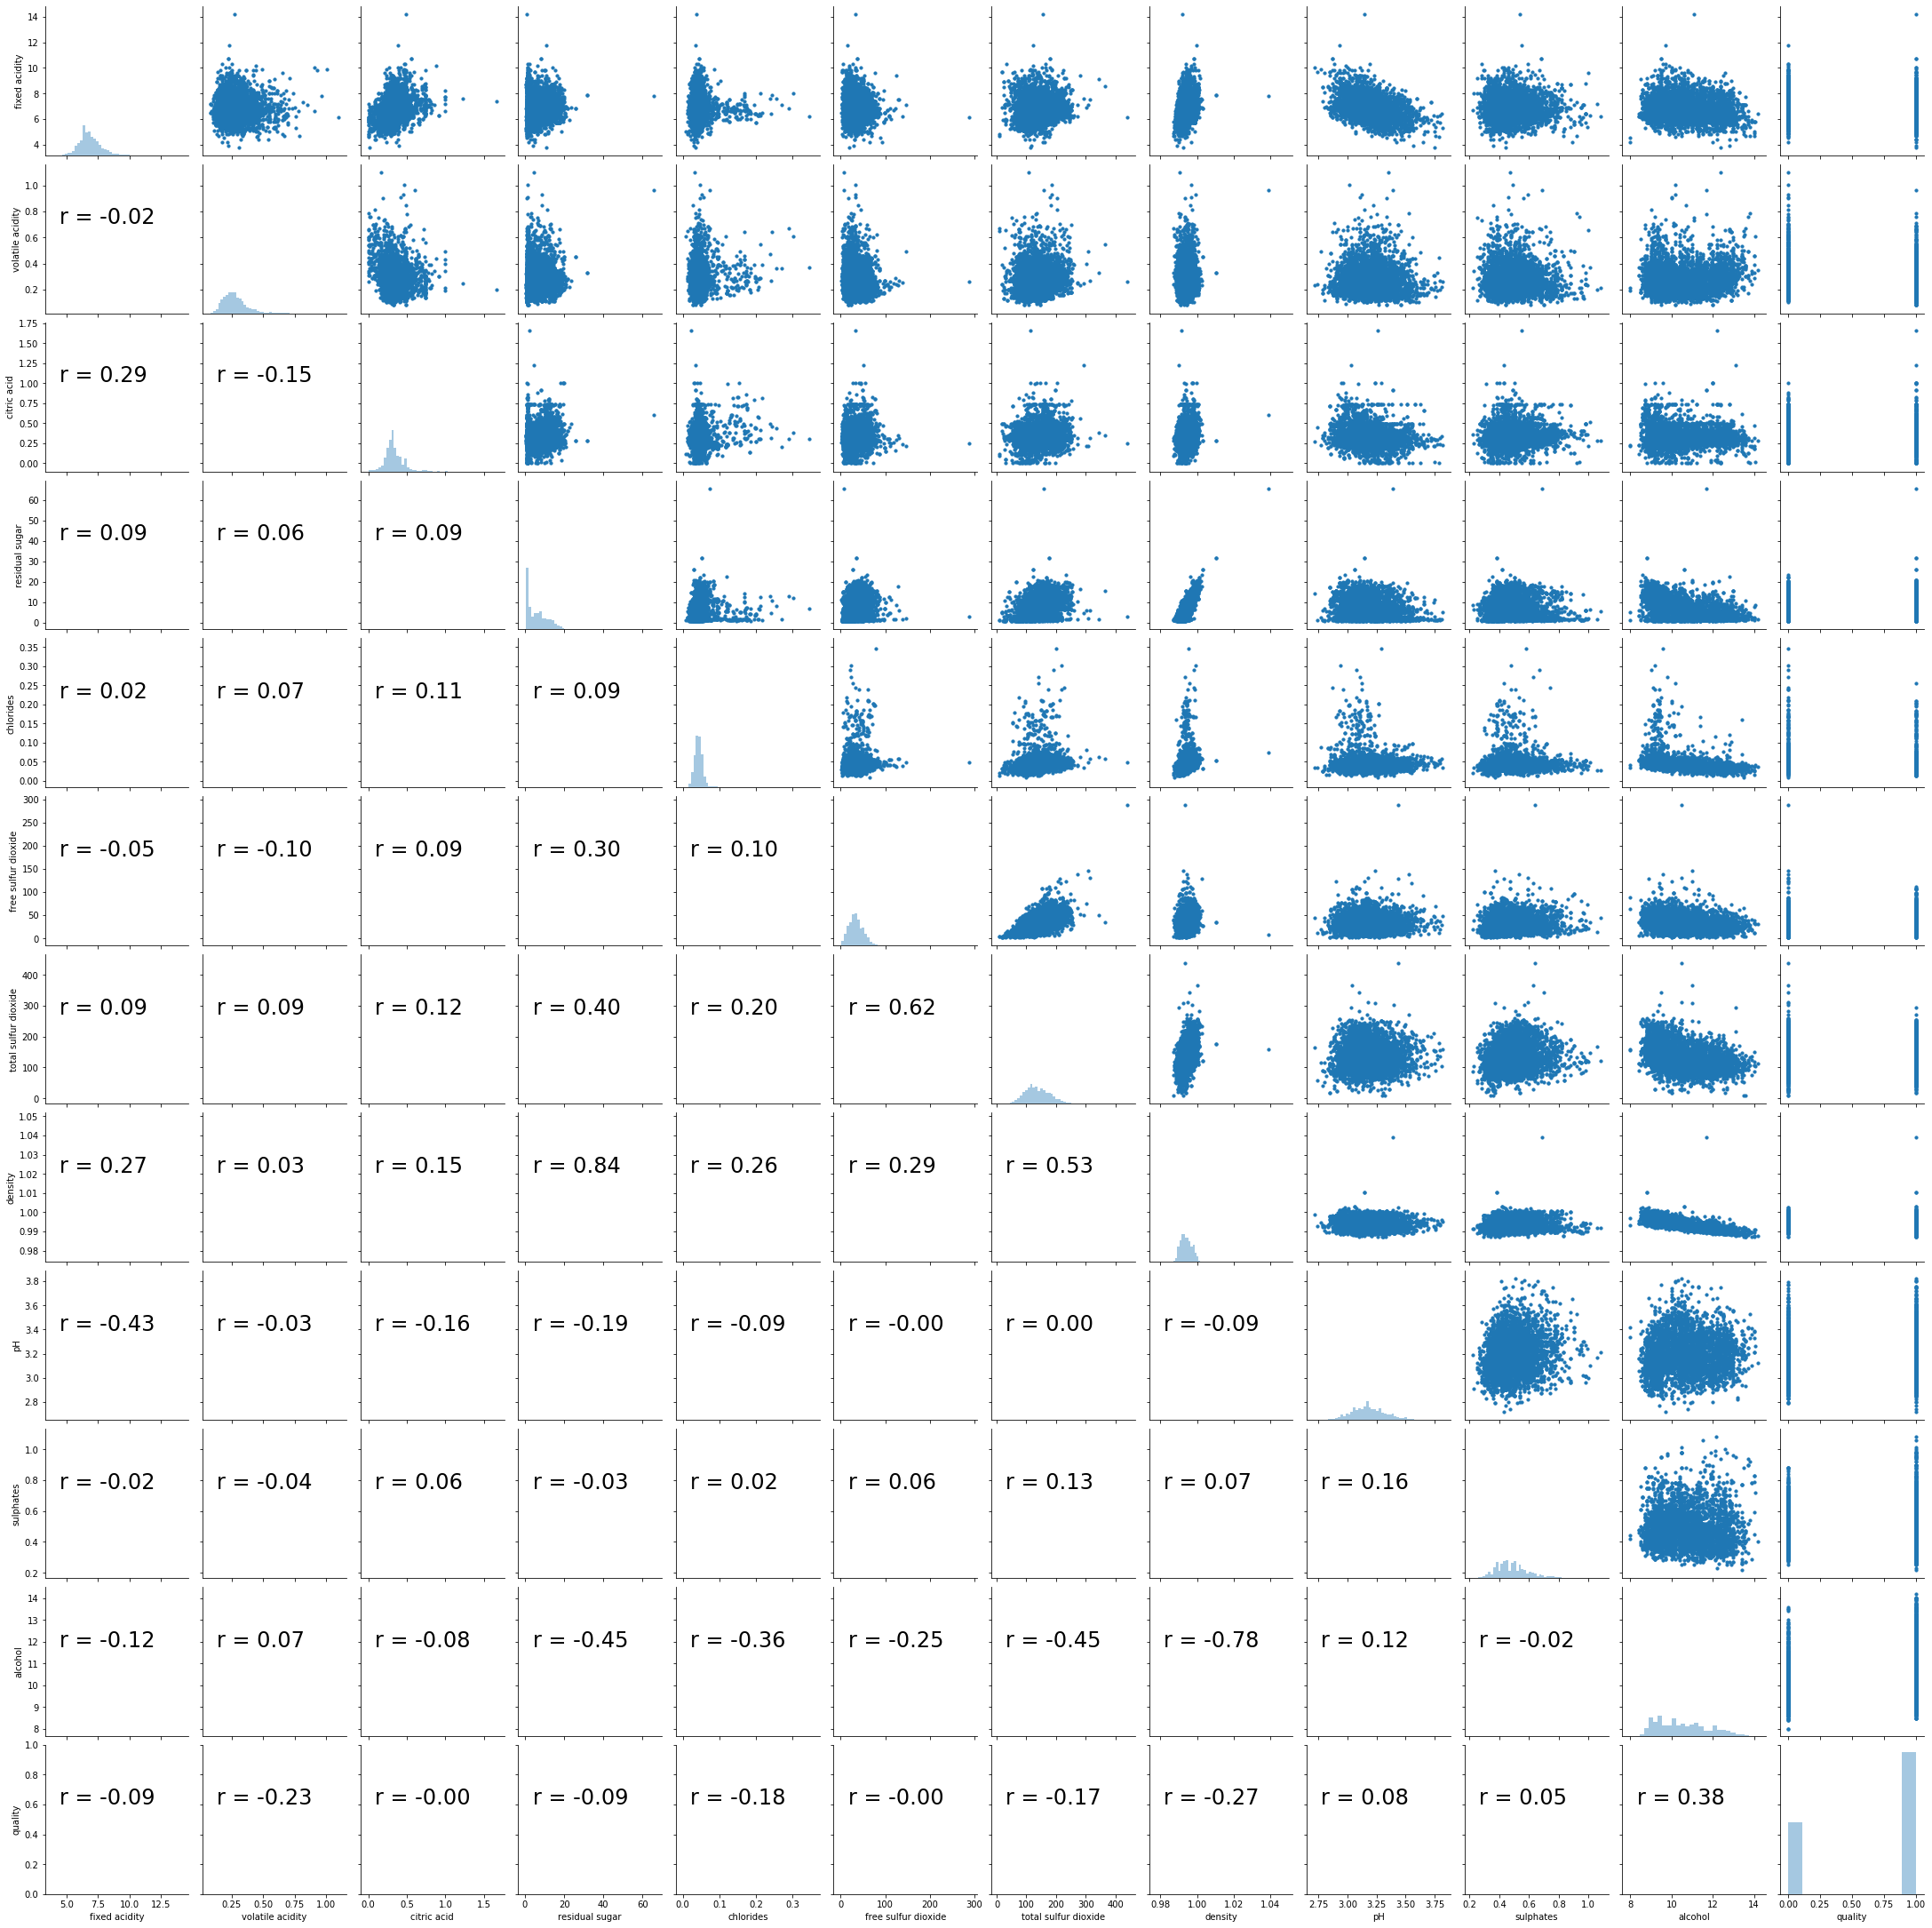

In [8]:
''' I liked the layout in the recitation, so I kept the same format:
upper is correlation graphs, diagonal is plots, lower is r-values.'''
def corr_plots(df):
    ''' Correlation function from recitation, which determines placement of r-values 
    when they're plotted, and calculates them. Cannot use df.corr() because it does 
    not meet the formatting of map_lower, but effectively does the same thing.'''
    def corrfunc(x, y, **kws):
        r, _ = stats.pearsonr(x, y)
        ax = plt.gca()
        ax.annotate("r = {:.2f}".format(r),
                    xy=(.1, .6), xycoords=ax.transAxes,
                   size = 24)

    fig = sns.PairGrid(df)
    fig.map_upper(plt.scatter, s=10)
    fig.map_diag(sns.distplot, kde=False)
    fig.map_lower(corrfunc)
    
corr_plots(df)

Total Sulfur Dioxide, Alcohol, and Residual Sugar all look like perfect candidates to drop.

In [8]:
# Drop redundant features.
df = df.drop(['total sulfur dioxide', 'alcohol', 'residual sugar'], axis=1)

This function just runs a naive KNN classifier, for Q17(a).

In [9]:
knn = KNN_Classifier()

features = df.drop('quality', axis=1)
target = df['quality']
train_features, test_features, train_target, test_target = partition(features, target, 0.2)

knn.fit(train_features, train_target, n_neighbors=5)
knn.predict(train_features)

print('Accuracy: ', Accuracy(train_target, knn.predictions))
print('F1 Score: ', F1_Score(train_target, knn.predictions))

Accuracy:  (0.7749114820435002, 0.22508851795649976)
F1 Score:  0.8381229538013824


This function standardizes and runs the KNN classifier, for Q17(c).

In [11]:
knn = KNN_Classifier()

features = df.drop('quality', axis=1)

# Scale features.
for feature in features.columns:
    features[feature] = (features[feature] - features[feature].mean())/features[feature].std()

target = df['quality']

train_features, test_features, train_target, test_target = partition(features, target, 0.2)

knn.fit(train_features, train_target, n_neighbors=5)
knn.predict(train_features)

print('Accuracy: ', Accuracy(train_target, knn.predictions))
print('F1 Score: ', F1_Score(train_target, knn.predictions))

Accuracy:  (0.8102471678681772, 0.1897528321318228)
F1 Score:  0.8627304898491339


Standardization worked better, so we kept it. Now we also try weighting by inverse distance, for Q17(e).

In [12]:
knn = KNN_Classifier()

features = df.drop('quality', axis=1)

# Scale features.
for feature in features.columns:
    features[feature] = (features[feature] - features[feature].mean())/features[feature].std()

target = df['quality']

train_features, test_features, train_target, test_target = partition(features, target, 0.2)

knn.fit(train_features, train_target, n_neighbors=5, weights='distance')
knn.predict(train_features)

print('Accuracy: ', Accuracy(train_target, knn.predictions))
print('F1 Score: ', F1_Score(train_target, knn.predictions))

C:\Users\MatAdamec\anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\MatAdamec\anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


Accuracy:  (1.0, 0.0)
F1 Score:  1.0


In [11]:
''' This function is for Q19, testing different models. '''
def model_benchmarks():
    features = df.drop('quality', axis=1)

    # Scale features.
    for feature in features.columns:
        features[feature] = (features[feature] - features[feature].mean())/features[feature].std()

    target = df['quality']

    train_features, test_features, train_target, test_target = partition(features, target, 0.2)
    
    start = time.time()
    model_tests = {'1EU': sFold(4, train_features, train_target, KNN_Classifier, F1_Score, n_neighbors=1, metric=Euclidean, weights='uniform'),
    '5EU': sFold(4, train_features, train_target, KNN_Classifier, F1_Score, n_neighbors=5, metric=Euclidean, weights='uniform'),
    '9EU': sFold(4, train_features, train_target, KNN_Classifier, F1_Score, n_neighbors=9, metric=Euclidean, weights='uniform'),
    '11EU': sFold(4, train_features, train_target, KNN_Classifier, F1_Score, n_neighbors=11, metric=Euclidean, weights='uniform'),
    '1MU': sFold(4, train_features, train_target, KNN_Classifier, F1_Score, n_neighbors=1, metric=Manhattan, weights='uniform'),
    '5MU': sFold(4, train_features, train_target, KNN_Classifier, F1_Score, n_neighbors=5, metric=Manhattan, weights='uniform'),
    '9MU': sFold(4, train_features, train_target, KNN_Classifier, F1_Score, n_neighbors=9, metric=Manhattan, weights='uniform'),
    '11MU': sFold(4, train_features, train_target, KNN_Classifier, F1_Score, n_neighbors=11, metric=Manhattan, weights='uniform'),
    '1ED': sFold(4, train_features, train_target, KNN_Classifier, F1_Score, n_neighbors=1, metric=Euclidean, weights='distance'),
    '5ED': sFold(4, train_features, train_target, KNN_Classifier, F1_Score, n_neighbors=5, metric=Euclidean, weights='distance'),
    '9ED': sFold(4, train_features, train_target, KNN_Classifier, F1_Score, n_neighbors=9, metric=Euclidean, weights='distance'),
    '11ED': sFold(4, train_features, train_target, KNN_Classifier, F1_Score, n_neighbors=11, metric=Euclidean, weights='distance'),
    '1MD': sFold(4, train_features, train_target, KNN_Classifier, F1_Score, n_neighbors=1, metric=Manhattan, weights='distance'),
    '5MD': sFold(4, train_features, train_target, KNN_Classifier, F1_Score, n_neighbors=5, metric=Manhattan, weights='distance'),
    '9MD': sFold(4, train_features, train_target, KNN_Classifier, F1_Score, n_neighbors=9, metric=Manhattan, weights='distance'),
    '11MD': sFold(4, train_features, train_target, KNN_Classifier, F1_Score, n_neighbors=11, metric=Manhattan, weights='distance')}
    end = time.time()
    
    return model_tests, end-start

benchmarks = model_benchmarks()

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


KeyboardInterrupt: 

In [14]:
for key in benchmarks[0]:
    print(key, benchmarks[0][key]['average error'])

1EU 0.8027602070155262
5EU 0.7962085308056872
9EU 0.8060176991150443
11EU 0.8029556650246306
1MU 0.8270734032411821
5MU 0.8193832599118943
9MU 0.8223791417707768
11MU 0.8197726862709724
1ED 0.7938751472320377
5ED 0.6647098667870851
9ED 0.6094562647754137
11ED 0.5815020526442888
1MD 0.7070435172723194
5MD 0.4421965317919075
9MD 0.28413882581900746
11MD 0.23737880307589435


In [15]:
best_knn = KNN_Classifier()
# 1MU was the best model. We create this, train it, and run on the test data.
best_knn.fit(train_features, train_target, n_neighbors=1, metric=Manhattan, weights='uniform')
best_knn.predict(test_features)

predicted = best_knn.predictions
expected = test_target

precision = Precision(expected, predicted)
recall = Recall(expected, predicted)
f1 = F1_Score(expected, predicted)
cm = ConfusionMatrix(expected, predicted)
accuracy, gen_e = Accuracy(expected, predicted)

print('Precision: ', precision, '\n')
print('Recall: ', recall, '\n')
print('F1 Score: ', f1, '\n')
print('Confusion Matrix: \n', cm, '\n')
print('Accuracy: ', accuracy, '\n')
print('Generalization Error: ', gen_e, '\n')

Precision:  0.8556390977443609 

Recall:  0.8569277108433735 

F1 Score:  0.8562829194883371 

Confusion Matrix: 
 [[569  96]
 [ 95 238]] 

Accuracy:  0.8086172344689379 

Generalization Error:  0.19138276553106215 



Note that TPR = recall, FPR = FP/(FP + TN). We now vary the threshold between 0 and 1, and plot the ROC curve, then determine the AUC.

In [16]:
def TPR(expected, predicted, **kwargs):
    return Recall(expected, predicted, **kwargs)

def FPR(expected, predicted, **kwargs):
    cm = ConfusionMatrix(expected, predicted, kwargs.pop('p', 1))
    return cm[0][1]/(cm[0][1] + cm[1][1])

thresholds = np.array([1.1, 1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0])
TPRs = np.array([])
FPRs = np.array([])
recalls = np.array([])
precisions = np.array([])

knn = KNN_Classifier()
for threshold in thresholds:
    knn.fit(train_features, train_target, n_neighbors=9, weights='uniform', metric=Manhattan, threshold=threshold)
    knn.predict(test_features)
    predicted = knn.predictions
    expected = test_target
    
    TPRs = np.append(TPRs, TPR(expected, predicted))
    FPRs = np.append(FPRs, FPR(expected, predicted))
    recalls = np.append(recalls, Recall(expected, predicted))
    precisions = np.append(precisions, Precision(expected, predicted))

C:\Users\MatAdamec\anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in long_scalars


(array([0.        , 0.29518072, 0.29518072, 0.50301205, 0.66716867,
        0.78012048, 0.86596386, 0.93222892, 0.9623494 , 0.98945783,
        0.99849398, 1.        ]),
 array([0.        , 0.02694611, 0.02694611, 0.08383234, 0.2245509 ,
        0.32335329, 0.46706587, 0.54191617, 0.72754491, 0.84131737,
        0.9491018 , 1.        ]),
 array([1.1, 1. , 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0. ]))

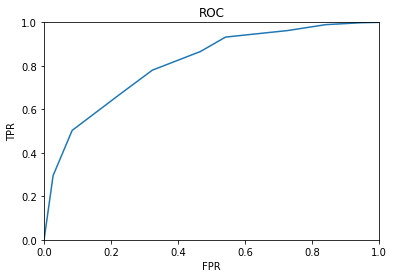

In [17]:
ROC(TPRs, FPRs)
AUC(TPRs, FPRs)
TPRs, FPRs, thresholds

(array([       nan, 0.95609756, 0.95609756, 0.92265193, 0.85521236,
        0.82747604, 0.78659371, 0.77375   , 0.7244898 , 0.70042644,
        0.67653061, 0.66533066]),
 array([0.        , 0.29518072, 0.29518072, 0.50301205, 0.66716867,
        0.78012048, 0.86596386, 0.93222892, 0.9623494 , 0.98945783,
        0.99849398, 1.        ]),
 array([1.1, 1. , 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0. ]))

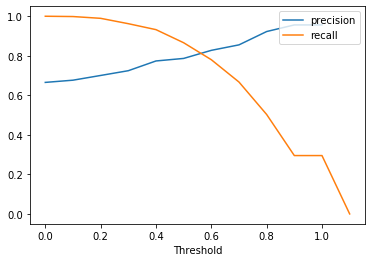

In [18]:
PrecisionRecallCurve(precisions, recalls, thresholds)
precisions, recalls, thresholds